# <a id="inicio"></a> Trabalho Final

-----

### **Autor:** Glauco Lauria Marques Filho

-----

# <a id="resumo"></a> Resumo 

#### Este arquivo contém a resolução do trabalho final do curso CEDS-808: Aprendizado de Máquina. Neste trabalho, o autor aplica algumas técnicas e modelos para realizar previsões e regressões acerca de dados de casos de dengue na cidade de Campinas/SP de 1998 a 2014.

* [Início](#inicio)
* [Resumo](#resumo)
* [Sumário](#sumario)
* [Importação de Requisitos](#requisitos)

1. [Origem dos Dados](#origem)
2. [Exploração Inicial](#exploracao)
3. [Tratamento de dados faltantes](#missingdata)
4. [Enriquecimento dos dados](#adddata)
5. [Exploração Avançada](#exploracao2)
6. [Remoção de Features](#remocao)
7. [Remoção de Outliers](#remocao2)

# <a id="requisitos"></a> Importação de Requisitos

In [225]:
import warnings
import seaborn as sns
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

# Suprimindo warnings de convergência
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# <a id="origem"></a> 1. Origem dos Dados


O dataset utilizado pelo autor pode ser encontrado nesse link do [Kaggle](https://www.kaggle.com/datasets/renangomes/dengue-temperatura-e-chuvas-em-campinassp/data). Basicamente se trata do número de casos mensais confirmados de dengue no municipio de Campinas/SP de 1998 a 2014, e dados de chuvas, temperatura média, mínima e máxima na cidade. O responsavel pelo dataset no Kaggle cita que os dados foram retirados dos orgãos SES (Secretaria Estadual de Saúde) e SINAN (Sistema de Informaçao de Agravos de Notificação). Os dados climaticos foram obtidos de tabelas encontradas em ciiagro.sp.gov.br.





# <a id="exploracao"></a> 2. Exploração Inicial

O conteúdo descrito no Kaggle é o seguinte:

* Mês: O mês no formato AAAA-MM-DD
* Casos confirmados: Total de casos de dengue confirmados no mês
* Chuva: Total em mm, de chuva na cidade no mês
* Temperatura Média/Mínima e Máxima: Temperatura diária Média/Mínima e Máxima

In [226]:
df = pd.read_csv(
    "dengue-dataset.csv",
    dtype={
        "data": str,
        "casos-confirmados": float,
        "chuva": float,
        "temperatura-media": float,
        "temperatura-mininima": float,
        "temperatura-maxima": float,
    },
)
df.describe(include='all')

,data,casos-confirmados,chuva,temperatura-media,temperatura-mininima,temperatura-maxima
count,204,204.000000,196.000000,204.000000,204.000000,204.000000
unique,204,NaN,NaN,NaN,NaN,NaN
top,1998-01-01,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN
mean,NaN,357.539216,116.650000,22.200980,17.679412,25.565196
std,NaN,1741.814759,96.631613,2.399363,3.336316,2.249864
min,NaN,0.000000,0.800000,16.400000,8.200000,19.100000
25%,NaN,6.000000,43.850000,20.100000,15.075000,23.800000
50%,NaN,17.500000,86.650000,22.700000,18.150000,26.200000
75%,NaN,84.500000,177.925000,24.225000,20.400000,27.200000


Pode-se, através do `describe`, ter uma ideia dos dados. O primeiro insight é de que estão faltando 8 dados de chuvas, já que todas as medidas possuem um `count` de 204, e chuva possui apenas 196. Possivelmente, existe um outlier em casos confirmados, pois alcanca a um máximo de mais de vinte mil casos em um mês, bem diferente da sua média de 357. Os tratamentos para esses dados serão vistos em itens futuros.

# <a id="missingdata"></a> 3. Tratamento de dados faltantes

Existem diversas técnicas para lidar com dados faltantes: usar a média, a moda ou remover a observação. Nesse caso, por se tratar de algo muito pontual (8 valores de chuvas), o autor decidiu procurar por fontes alternativas para lidar com esses dados. O autor encontrou um [site](https://www.cpa.unicamp.br/graficos) ligado à Unicamp, que possui o registro de chuvas, e então coletou os valores faltantes.

 | Data | chuva |
   |---|---|
   | 1999-07-01 | 2 |
   | 1999-08-01 | 0 |
   | 2002-06-01 | 0 |
   | 2004-08-01 | 0 |
   | 2007-08-01 | 0 |
   | 2008-07-01 | 191 |
   | 2010-08-01 | 0 |
   | 2012-08-01 | 0 |


In [227]:
df.iat[18, 2] = 2
df.iat[19, 2] = 0
df.iat[53, 2] = 0
df.iat[79, 2] = 0
df.iat[115, 2] = 0
df.iat[126, 2] = 191
df.iat[151, 2] = 0
df.iat[175, 2] = 0

# <a id="adddata"></a> 4. Enriquecimento dos dados

Nos modelos iniciais testados durante a confeccao desse trabalho o R2 obtido na regressao nao passava de 0.14, um valor bem baixo, para tentar melhorar isso o autor decidiu de alguma maneira enriquecer os dados, foi percebida uma falta de dados que demonstrassem o crescimento da populacao ao longo dos anos, pois se a populacao cresce muito e os numeros de casos de dengue nao cresce em mesma proporcao, isso indicaria uma melhora no cenario da doenca.
Para adicionar esse dado foram consultados os Sensos do IBGE para a cidade de Campinas. Os dados pertinentes sao:

 | Ano | Habitantes |
   |---|---|
| 1991-01-01 | 847595|
|2000-01-01 | 969396|
|2010-01-01 | 1080999|
|2022-01-01 | 1139047|

Dados falsos de referencia para 1991 e 2022 serao adicionados ao dataframe, sera realizada uma interpolacao linear para demonstrar o crescimento da populacao no periodo amostrado e entao removidos os dados falsos iniciais. Com isso foi calculada uma nova coluna, casos para cada 100mil habitantes (casos_p_100k), uma medida bem mais confiavel do que os casos absolutos.

In [228]:
linha_0 = pd.DataFrame({
    "data": ["1991-01-01"],
    "casos-confirmados": [0],
    "chuva": [0],
    "temperatura-media": [0],
    "temperatura-mininima": [0],
    "temperatura-maxima": [0]}
)
linha_205 = pd.DataFrame({
    "data": ["2022-01-01"],
    "casos-confirmados": [0],
    "chuva": [0],
    "temperatura-media": [0],
    "temperatura-mininima": [0],
    "temperatura-maxima": [0]}
)

df = pd.concat([linha_0, df], ignore_index=True)
df = pd.concat([df, linha_205], ignore_index=True)

populacao = {
    pd.Timestamp("1991-01-01"): 847595,
    pd.Timestamp("2000-01-01"): 969396,
    pd.Timestamp("2010-01-01"): 1080999,
    pd.Timestamp("2022-01-01"): 1139047,
}

df["data"] = pd.to_datetime(df["data"])
df["populacao"] = df["data"].map(populacao)
df["populacao"] = df["populacao"].interpolate(method="linear")
df["populacao"] = df["populacao"].astype(int)

df["casos_p_100k"] = df["casos-confirmados"] / (df["populacao"]/100000)

df.drop(index=[0, 205], inplace=True)

with pd.option_context('display.max_rows', 6, 'display.max_columns', None):
    print(df[["data","casos-confirmados","populacao","casos_p_100k"]])


          data  casos-confirmados  populacao  casos_p_100k
1   1998-01-01              237.0     852467     27.801663
2   1998-02-01              331.0     857339     38.607832
3   1998-03-01              562.0     862211     65.181261
..         ...                ...        ...           ...
202 2014-10-01               40.0    1136144      3.520680
203 2014-11-01               57.0    1137112      5.012699
204 2014-12-01               37.0    1138079      3.251092

[204 rows x 4 columns]


Com isso foi obitda a evolucao teorica da populacao ao longo dos meses do periodo de amostragem.

De forma a complementar mais uma vez o dataset foi decidido trazer informacoes de investimento em saude anual do municipio. Na teoria um maior investimento em Saude traria uma maior campanha dos orgaos de vigilancia sanitaria assim como programas de conscientizacao da doenca. Para trazer esse indicador foram consultadas LOAs (Lei Orcamentaria Anual), diario oficial e noticias de jornal, foi possivel reunir alguns orcamentos da saude municipal, porem faltaram alguns dados, 2005, 2004, 2003, 2001, 1999 e 1998, esses faltantes tambem foram calculados com interpolacao. Importante lembrar que os dados tambem foram corrigidos pela inflacao utilizando o IPCA. Com os dados de investimento tambem calcularemos uma nova coluna, investimento em saude por habitante (investimento_p_habitante).

Os dados obtidos foram:

 | Ano | Orcamento | Corr. Infla. | Orcamento Final |
   |---|---|---|---|
| 1998 | - | - | 784238273.22 |
| 1999 | - | - | 792559136.61 |
| 2000 | 188000000 | 4.26 | 800880000.00 |
| 2001 | - | - | 809200863.39 |
| 2002 | 218588697 | 3.74 | 817521726.78 |
| 2003 | - | - | 880141045.08 |
| 2004 | - | - | 939141044.39 |
| 2005 | - | - | 1008332363.69 |
| 2006 | 400000000 | 2.67 | 1068000000.00 |
| 2007 | 445000000 | 2.59 | 1152550000.00 |
| 2008 | 518200000 | 2.48 | 1285136000.00 |
| 2009 | 654000000 | 2.34 | 1530360000.00 |
| 2010 | 717517988 | 2.24 | 1607240293.12 |
| 2011 | 807363166 | 2.12 | 1711609911.92 |
| 2012 | 846603134 | 1.99 | 1684740236.66 |
| 2013 | 1000262264 | 1.88 | 1880493056.32 |
| 2014 | 1027369524 | 1.78 | 1828717752.72 |
| 2015 | 1115767005 | 1.67 | 1863330898.35 |



In [229]:
investimento_saude = {
    2015: 1115767005.00 * 1.67,
    2014: 1027369524.00 * 1.78,
    2013: 1000262264.00 * 1.88,
    2012: 846603134.00 * 1.99,
    2011: 807363166.00 * 2.12,
    2010: 717517988.00 * 2.24,
    2009: 654000000.00 * 2.34,
    2008: 518200000.00 * 2.48,
    2007: 445000000.00 * 2.59,
    2006: 400000000.00 * 2.67,
    2002: 218588697.00 * 3.74,
    2000: 188000000.00 * 4.26,
    2005: 1008332363.695,
    2004: 939141044.39,
    2003: 880141045.085,
    2001: 809200863.39,
    1999: 792559136.61,
    1998: 784238273.22,
}

# Transformando a coluna data para mês e ano inteiro
df["mes"] = df["data"].dt.month
df["ano"] = df["data"].dt.year
df["mes"] = df["mes"].astype(int)
df["ano"] = df["ano"].astype(int)
del df["data"]

# Adicionando o investimento em saude anual
df["investimento_saude"] = df["ano"].map(investimento_saude)

df["investimento_p_habitante"] = df["investimento_saude"] / (df["populacao"])

with pd.option_context('display.max_rows', 6, 'display.max_columns', None):
    print(df[["ano", "mes", "investimento_saude", "investimento_p_habitante"]])


      ano  mes  investimento_saude  investimento_p_habitante
1    1998    1        7.842383e+08                919.963205
2    1998    2        7.842383e+08                914.735330
3    1998    3        7.842383e+08                909.566537
..    ...  ...                 ...                       ...
202  2014   10        1.828718e+09               1609.582723
203  2014   11        1.828718e+09               1608.212518
204  2014   12        1.828718e+09               1606.846056

[204 rows x 4 columns]


Depois desses dados adicionados os modelos foram rodados novamente em o R2 passou de 0.14 para 0.50+, uma melhora bem significativa.

# <a id="exploracao2"></a> 5. Exploração Avançada

Depois das transformacoes ocorridas no item anterior o target mudou pra (casos_p_100k). Para verificar a distribuicao dos valores de casos foi definido arbitrariamente 3 faixas de risco, 0 ate 50 casos por 100mil habitantes foi definido como classe de Baixo Risco. 51 ate 100 casos por 100mil habitantes sera de Medio Risco, mais que 100 casos por 100mil habitantes sera um caso de Alto Risco. Em itens futuros sera trabalhado a previsao da classe de risco, e essas definicoes sera reutilizadas. Por hora sera feita apenas uma regressao, e essas faixas serao uteis para visualizar o comportamento dos dados.

In [230]:
baixo_limite = 50
medio_limite = 100

Um grafico de densidade dos casos por 100mil habitantes podera ajudar a visualizar o comportamento dos dados.

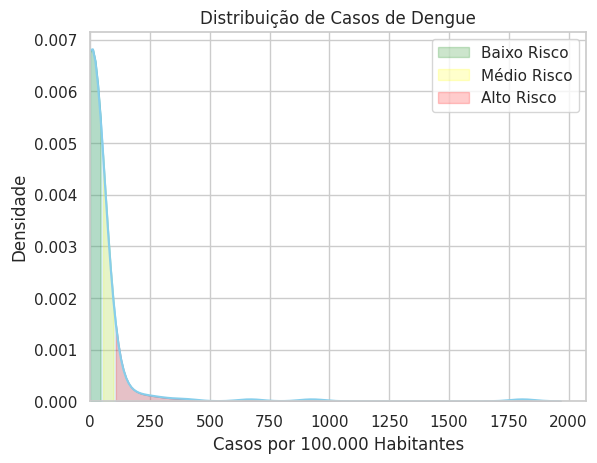

In [231]:
sns.kdeplot(data=df, x="casos_p_100k", fill=True, color="skyblue")

density = sns.kdeplot(data=df['casos_p_100k'], color="skyblue").get_lines()[0].get_data()

plt.fill_between(density[0], density[1], color='green', alpha=0.2, where=(density[0] <= baixo_limite), label='Baixo Risco')
plt.fill_between(density[0], density[1], color='yellow', alpha=0.2, where=((density[0] > baixo_limite) & (density[0] <= medio_limite)), label='Médio Risco')
plt.fill_between(density[0], density[1], color='red', alpha=0.2, where=(density[0] > medio_limite), label='Alto Risco')

plt.legend()
plt.xlim(0)
plt.xlabel('Casos por 100.000 Habitantes')
plt.ylabel('Densidade')
plt.title('Distribuição de Casos de Dengue')

plt.show()


Mais uma vez pode-se verificar a possivel presenca de outliers, a maior parte dos dados ficam entre 0 e 500 casos, porem temos valores extremamente altos. Em itens futuros serao feitos alguns tratamentos sobre esses outliers.

Para visualizar o comportamento de todas as features sera feito um Violin plot.

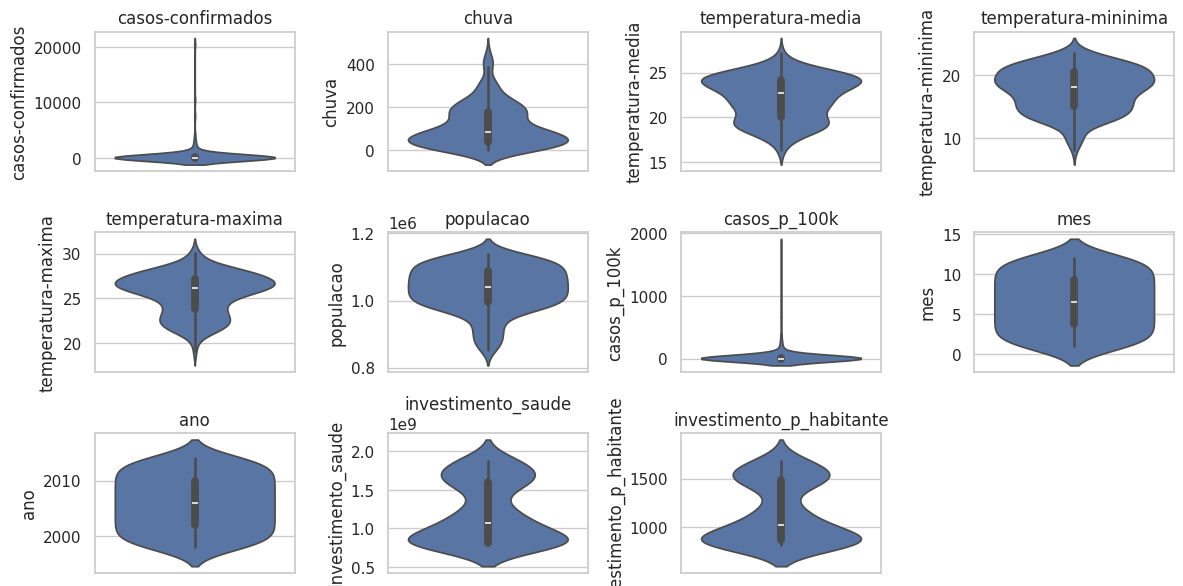

In [232]:
plt.figure(figsize=(12, 8))
for i, column in enumerate(df.columns, 1):
    plt.subplot(4, 4, i)
    sns.violinplot(y=df[column])
    plt.title(column)

plt.tight_layout()
plt.show()

Pelo grafico tudo indica que apenas as targets possuem outliers. Sera plotado agora uma matriz de correlacao para verificar a correlacao entre as medidas.

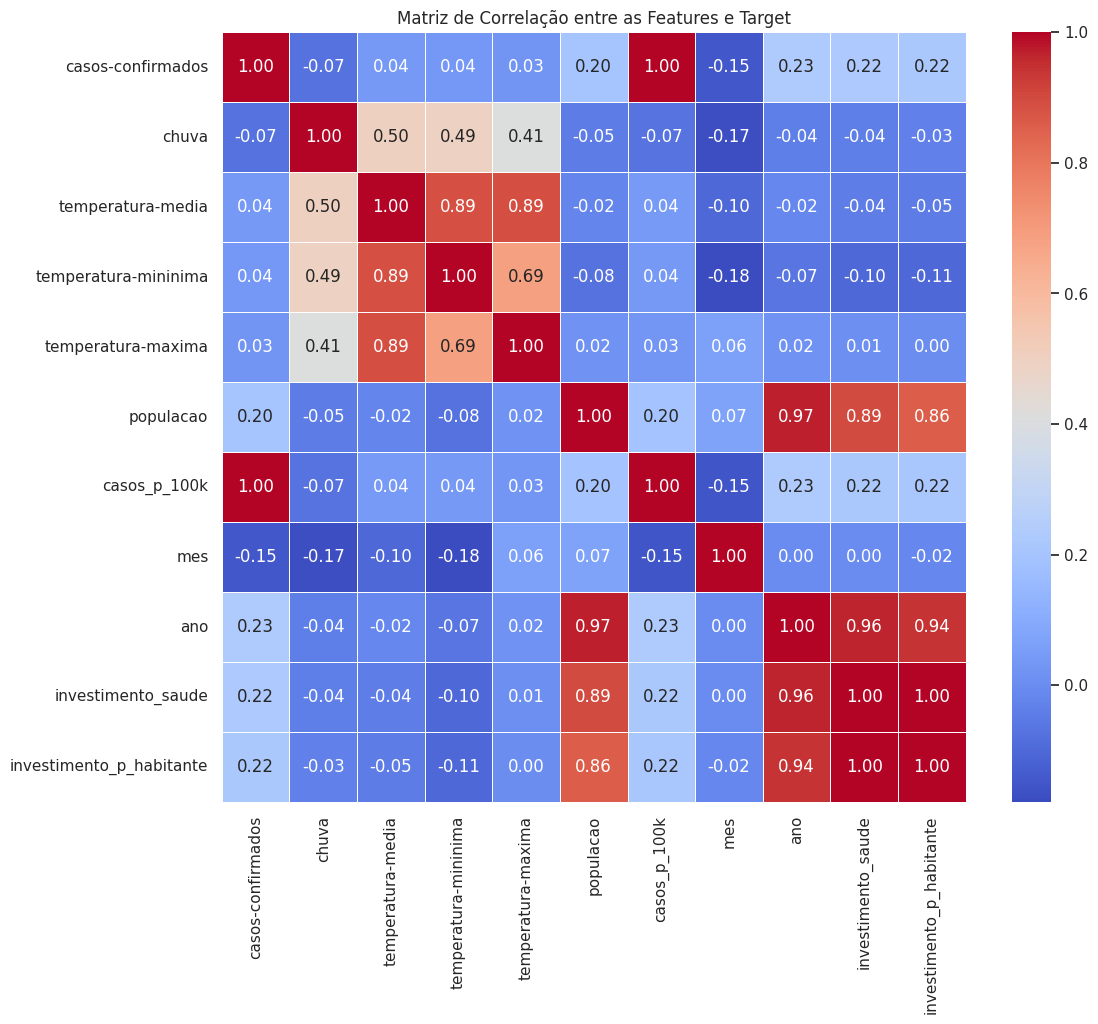

In [233]:
correlation_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlação entre as Features e Target')
plt.show()

De acordo com o grafico existe uma alta correlacao entre Ano, Investimento, Investimento por habitante e Populacao, isso era esperado, pois algumas dessas medidas foram derivadas de outras, isso sera resolvido nos proximos itens. Assim como existe alta correlacao entre Temperatura Maxima e Minima com a Temperatura Media.

# <a id="remocao"></a> 6. Remoção de Features

Para lidar com problemas de alta correlacao e remocao de dados nao pertinentes algumas features serao removidas.

* Investimento em Saude sera removido pois sera considerado no modelo apenas o Investimento por Habitante.
* Casos Confirmados sera removido pois sera considerado no modelo apenas Caso por 100mil Habitantes.
* Populacao sera removida pois existe uma alta correlacao dela com Investimento por Habitante e Casos por Habitante.
* Ano tambebm sera removido pois existe uma alta correlacao dele com Investimento por Habitante e Casos por Habitante.
* Temperatura Maxima sera removida pois existe uma alta correlacao dela com Temperatura Media.
* Temperatura Minima sera removida pois existe uma alta correlacao dela com Temperatura Media.

In [234]:
df_original = df.copy()
del df["investimento_saude"]
del df["populacao"]
del df["casos-confirmados"]
del df["ano"]
del df["temperatura-mininima"]
del df["temperatura-maxima"]

Apos as remocoes o grafico de correlacao fica da seguinte maneira:

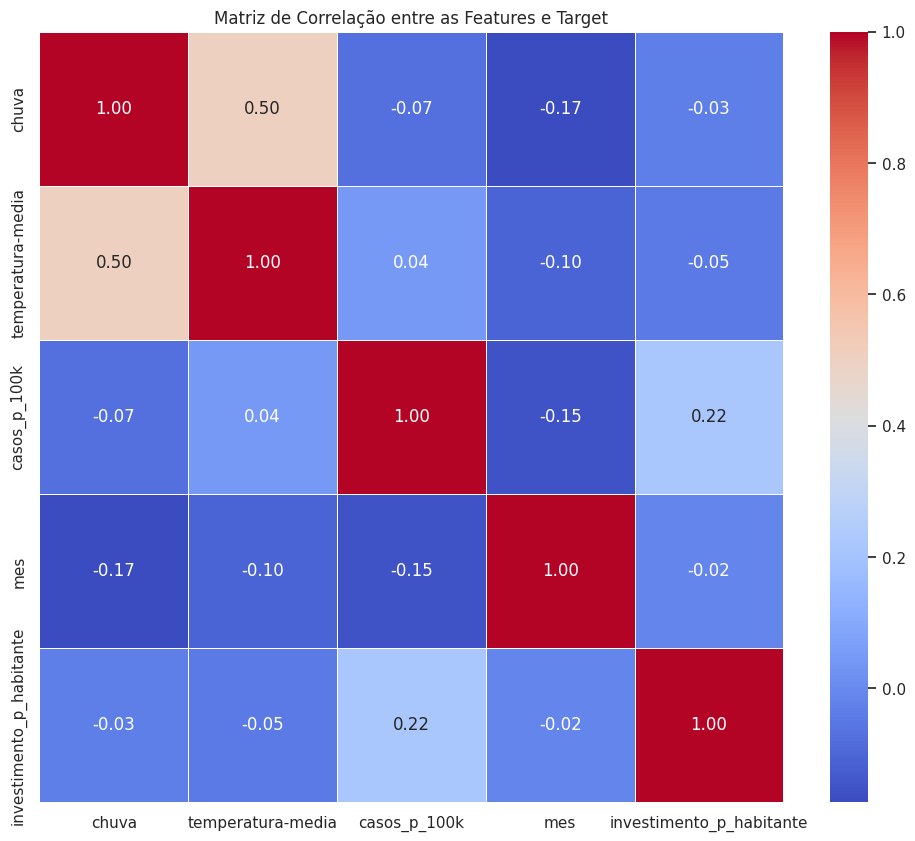

In [235]:
correlation_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlação entre as Features e Target')
plt.show()

# <a id="remocao2"></a> 7. Remoção de Features

Para verificar se as amostras com um altissimo numero de casos sao de fato Outliers causados por algum problema na coleta vamos listar os maiores casos e entao procurar um historico na internet se esse cenario de fato ocorreu.

In [236]:
df_original = df_original.sort_values(by="casos-confirmados",ascending=False)
with pd.option_context('display.max_rows', 14, 'display.max_columns', None):
    print(df_original[["ano","mes","casos-confirmados","casos_p_100k"]])

      ano  mes  casos-confirmados  casos_p_100k
196  2014    4            20428.0   1807.245437
197  2014    5            10484.0    926.715737
195  2014    3             7555.0    668.955844
112  2007    4             4207.0    400.549172
111  2007    3             3213.0    306.181376
..    ...  ...                ...           ...
68   2003    8                0.0      0.000000
79   2004    7                0.0      0.000000
22   1999   10                0.0      0.000000
23   1999   11                0.0      0.000000
78   2004    6                0.0      0.000000

[204 rows x 4 columns]


In [237]:
# Remoção de Outliers
df = df.drop(df[df["casos_p_100k"] > 500].index)

In [238]:
# Definindo features e target
X = df.copy()
del X["casos_p_100k"]
y = df["casos_p_100k"]


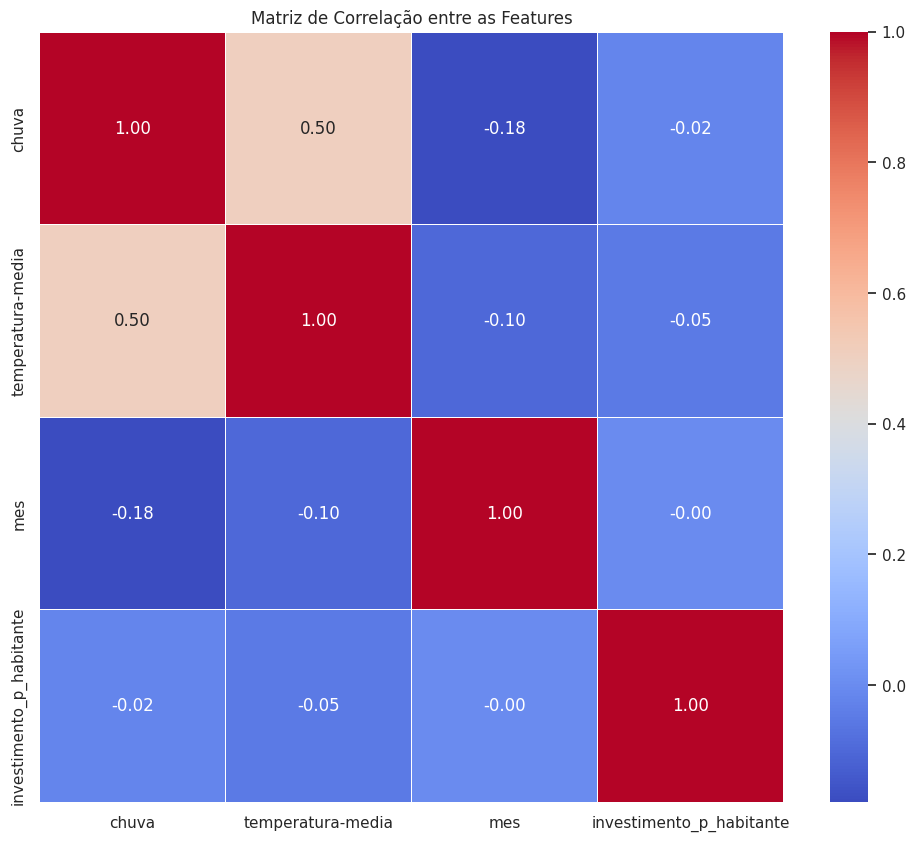

In [239]:
correlation_matrix = X.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlação entre as Features')
plt.show()

In [240]:
# Padronizando os dados
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [241]:
# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [242]:
# Modelos a serem testados
models = {
    "KNN": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "SVM": SVR(),
    "Multi-layer Perceptron": MLPRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": xgb.XGBRegressor(),
}

max_depth = [None]
valor = 1
while valor <=30:
    max_depth.append(int(valor))
    valor = valor + 1

C = []
valor = 1.0
while valor <= 500:
    C.append(valor)
    valor += 1.0

epsilon = []
valor = 0.01
while valor <= 1:
    epsilon.append(valor)
    valor += 0.01

params = {
    "KNN": {"n_neighbors": list(range(16,31))}, # 1-100 achou 23
    "Decision Tree": {"max_depth": max_depth},
    "SVM": {"C": C, "epsilon": [0.1, 0.2, 0.5, 1]}, # achou c 218, ep 0.2
    "Multi-layer Perceptron": {
        "hidden_layer_sizes": [(50,), (100,), (50, 50), (100, 100)]
    },
    "Random Forest": {
        "n_estimators": [10, 50, 100, 150, 200, 250, 300, 350, 400, 450],  # 45
        "max_depth": [None, 5, 10, 15, 20, 25, 30, 35, 40, 45],   # 10
    },
    "Gradient Boosting": {
        "n_estimators": [50, 100, 150, 200],
        "learning_rate": [0.01, 0.1, 0.5, 1],
    },
    "XGBoost": {
        "n_estimators": [50, 100, 150, 200],
        "learning_rate": [0.01, 0.1, 0.5, 1],
    },
}


In [243]:
# # Realizando Grid Search com validação cruzada
# for name, model in models.items():
#     print(f"Training {name}...")
#     grid_search = GridSearchCV(model, params[name], cv=5, scoring="r2")
#     grid_search.fit(X_train, y_train)
#     best_model = grid_search.best_estimator_
#     print(f"Best Parameters: {grid_search.best_params_}")
#     predictions = best_model.predict(X_test)
#     r2 = r2_score(y_test, predictions)
#     print(f"{name} R2 Score:", r2)
    
#     # Fazendo previsões para todo o conjunto de dados
#     predictions = best_model.predict(X)
    
#     # Plotando gráfico de previsão versus valor real ao longo do tempo
#     plt.figure()
#     plt.plot(range(len(y)), y, label='Valor Real')
#     plt.plot(range(len(predictions)), predictions, label='Previsão')
#     plt.xlabel('Evento')
#     plt.ylabel('Valor')
#     plt.title(f'Previsão vs Valor Real - {name}')
#     plt.legend()
#     plt.show()
